# Data Modeling 01

In this notebook, we'll begin building the classifier to show that Layer 4 neurons do not exist in the organoid data. We will do this in the following manner.

1. Identify cells in the primary data by which layer of the cortex they are in.
2. Train a classifier on the primary data.
3. Under the assumption that the space of gene expression is the same in organoids, classify the organoid cells to their respective cortex layer and show that none get classified as layer 4.
4. Conclude that layer 4 cells do not exist in the organoid data.

In [67]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import umap
import hdbscan
from collections import Counter
import seaborn as sns
import plotly.express as px 
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [68]:
primary = pd.read_csv('primary_labels_test.csv')
df = pd.read_csv('../data/processed/primary_reduction_neighbors_500_components_100.csv', index_col='Unnamed: 0')
df['label'] = primary['label']

In [69]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,1.174407,4.605017,5.700520,4.349964,0.009240,4.443735,4.977513,1.097707,4.923816,5.728352,...,6.758616,3.999133,4.044898,4.987543,1.790490,4.197807,6.984423,9.260715,7.174916,4
1,1.187639,4.608121,5.704485,4.363834,0.024695,4.443859,4.973516,1.105194,4.919911,5.728892,...,6.762886,3.999778,4.040472,4.999935,1.792208,4.192843,6.986716,9.258625,7.172100,11
2,1.179722,4.631567,5.731539,4.270429,0.007747,4.434293,4.971396,1.129670,4.909443,5.748357,...,6.765180,4.005325,4.039588,5.014343,1.786922,4.206350,6.986751,9.256733,7.179493,4
3,1.233760,4.637250,5.735640,4.311743,0.078151,4.433172,4.963012,1.207390,4.900370,5.740662,...,6.769579,3.998335,4.026979,4.999375,1.817481,4.194461,6.987063,9.243600,7.164564,5
4,1.188722,4.624152,5.721036,4.324148,0.035837,4.437555,4.966181,1.132194,4.908939,5.740864,...,6.764676,4.001324,4.034964,5.004535,1.799192,4.201400,6.986776,9.252455,7.172283,11


Now we begin the classification process

In [70]:
class GeneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=100, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=primary['label'].nunique()),
        )
        
    def forward(self, x):
        return self.network(x)

Now that we've defined a basic fully connected neural network, let's split our data into training and testing sets, then use K-fold CV to tune the architecture of our model

In [71]:
X = df.drop('label', axis=1).values
y = [x+1 for x in df['label'].values] # So we dont have a label value of -1, noise is now label=0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Great, now we can define our loss function, optimization algorithmn and a model instance and get to work!

In [72]:
model = GeneClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model

GeneClassifier(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=15, bias=True)
  )
)

Finally, we can train our model and view the accuracy on the test set.

In [87]:
epochs = 10000
loss_arr = []
stop_tol = 50
stopping = 0

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)

    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
    
    if i > 1:
        if loss_arr[i].item() > loss_arr[i-1].item():
            stopping += 1
        else:
            stopping = (0 if stopping == 0 else stopping - 1)
    
    if stopping == stop_tol:
        print(f'Reached stopping criterion at iteration {i}')
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.6625729203224182
Epoch: 10 Loss: 0.6636262536048889
Epoch: 20 Loss: 0.6549345850944519
Epoch: 30 Loss: 0.7396190166473389
Epoch: 40 Loss: 0.8023156523704529
Epoch: 50 Loss: 0.7407172322273254
Epoch: 60 Loss: 0.6607627868652344
Epoch: 70 Loss: 0.6531257033348083
Epoch: 80 Loss: 0.6486878395080566
Epoch: 90 Loss: 0.6450058221817017
Epoch: 100 Loss: 0.6437074542045593
Epoch: 110 Loss: 0.6420813798904419
Epoch: 120 Loss: 0.6447199583053589
Epoch: 130 Loss: 0.6405091285705566
Epoch: 140 Loss: 0.6597336530685425
Epoch: 150 Loss: 0.6403116583824158
Epoch: 160 Loss: 0.9066668152809143
Epoch: 170 Loss: 0.8605571985244751
Epoch: 180 Loss: 0.754325807094574
Epoch: 190 Loss: 0.7094987034797668
Epoch: 200 Loss: 0.6634676456451416
Epoch: 210 Loss: 0.6649220585823059
Epoch: 220 Loss: 0.6392096877098083
Epoch: 230 Loss: 0.6396535634994507
Epoch: 240 Loss: 0.6353840827941895
Epoch: 250 Loss: 0.6343037486076355
Epoch: 260 Loss: 0.6330943703651428
Epoch: 270 Loss: 0.6323433518409729
Epoc

KeyboardInterrupt: 

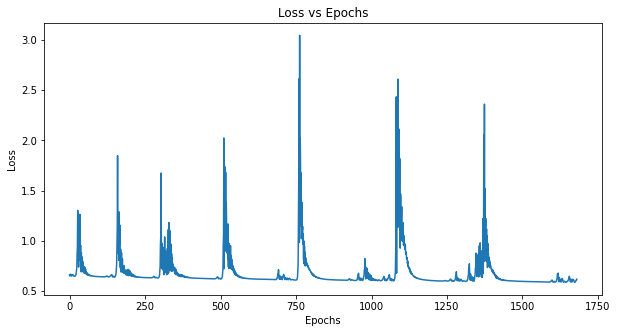

In [89]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_arr)), [x.item() for x in loss_arr]);
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.title('Loss vs Epochs');

We need to train this model much more on the full feature space with regularization methods, so for now let's try some simpler models like SVM's and tree methods

In [34]:
svc = SVC()
parameters = {
    'C': [0.1, 0.25, 0.5, 0.75, 1],
}

est = GridSearchCV(svc, parameters, verbose=100)

In [ ]:
model = est.fit(X_train, y_train).best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
